In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = '/mnt/g/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [28]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scp

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    # else:
    #     data = [wfdb.rdsamp(path+f) for f in df.filename_hr
    data = np.array([signal for signal, meta in data])
    return data

path = '/mnt/g/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
# Ypos = Y.loc[Y['scp_codes'].str.contains("{'NORM': 100.0}") == True]
Ypos = Y.loc[Y['scp_codes'].str.contains("{'SARRH':") == True]

# # Load raw signal data
# X = load_raw_data(Ypos, sampling_rate, path)
# print(X.shape)
# X2chan = np.squeeze(X[:,:,1])
# scp.savemat("data.mat",{'data':X2chan})

ptb = pd.read_csv(path+'ptbdb_normal.csv',header = None)
ptb_ab = pd.read_csv(path+'ptbdb_abnormal.csv',header = None)
print('Normal ECG')
norm = np.array(ptb.iloc[:,:187])
norm_training, norm_test = norm[:int(0.9*norm.shape[0]),:],norm[int(0.9*norm.shape[0]):,:]
print(norm_training.shape, norm_test.shape)
print('Abnormal ECG')
abnorm = np.array(ptb_ab.iloc[:4046,:187])
abnorm_training, abnorm_test = abnorm[:int(0.9*abnorm.shape[0]),:],abnorm[int(0.9*abnorm.shape[0]):,:]
print(abnorm_training.shape, abnorm_test.shape)
x_training = np.vstack((norm_training,abnorm_training))
x_test = np.vstack((norm_test,abnorm_test))
print(x_training.shape,x_test.shape)
y_training_pos = np.ones((norm_training.shape[0],1))
y_training_neg = np.zeros((abnorm_training.shape[0],1))
y_training = np.vstack((y_training_pos,y_training_neg))

y_test_pos = np.ones((norm_test.shape[0],1))
y_test_neg = np.zeros((abnorm_test.shape[0],1))
y_test = np.vstack((y_test_pos,y_test_neg))

print(y_training.shape,y_test.shape)


Normal ECG
(3641, 187) (405, 187)
Abnormal ECG
(3641, 187) (405, 187)
(7282, 187) (810, 187)
(7282, 1) (810, 1)


In [41]:
from keras import Sequential
from keras.layers import Dense,Activation,Dropout
model = Sequential([
    Dense(5, input_shape=(187,)),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    Dense(15),
    Activation('relu'),
    Dense(30),
    Activation('relu'),
    Dense(15),
    Activation('relu'),
    Dense(10),
    Activation('relu'),
    # Dense(5),
    # Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_training, y_training, batch_size=32, epochs=60)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 5)                 940       
_________________________________________________________________
activation_62 (Activation)   (None, 5)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 10)                60        
_________________________________________________________________
activation_63 (Activation)   (None, 10)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 15)                165       
_________________________________________________________________
activation_64 (Activation)   (None, 15)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 30)              

Test loss: 0.21539217292526622
Test accuracy: 0.9209876656532288
[[0.8933532]]


Text(0.5, 0, 'Epoch')

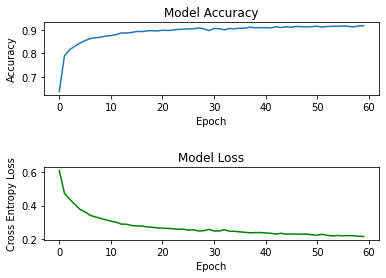

In [45]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(model.predict(np.expand_dims(x_test[56 ,:],axis =0 )))

fig, axes = plt.subplots(2,1)
axes[0].plot(history.history['accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

fig.subplots_adjust(hspace=1)

axes[1].plot(history.history['loss'], 'g')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Cross Entropy Loss')
axes[1].set_xlabel('Epoch')


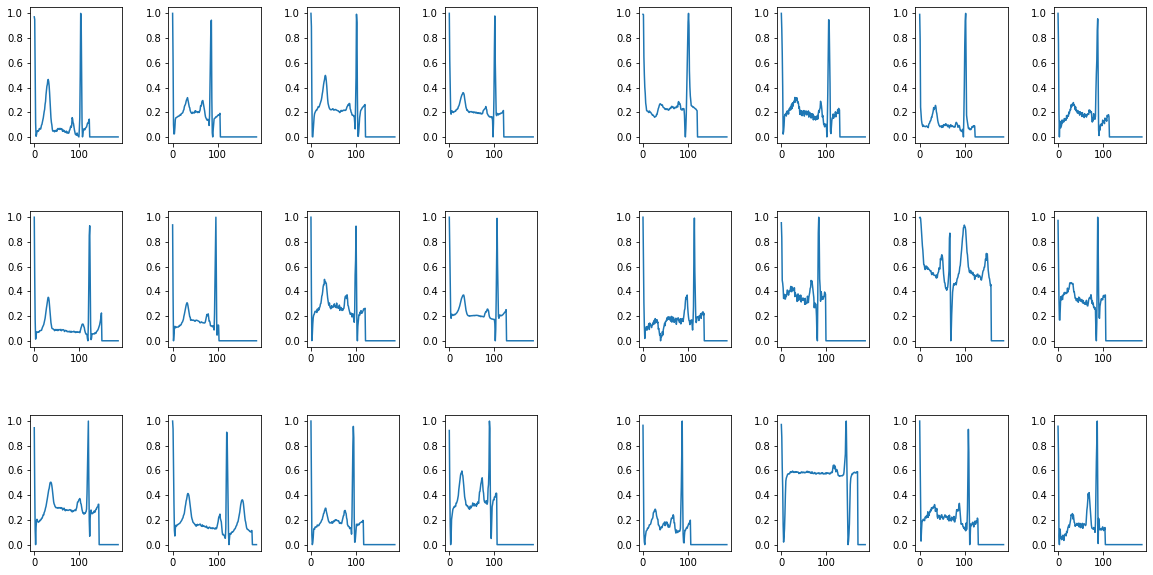

In [43]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

for i in range(2):
    inner = gridspec.GridSpecFromSubplotSpec(3, 4,
                    subplot_spec=outer[i], wspace=0.5, hspace=0.5)

    for j in range(12):
        ax = plt.Subplot(fig, inner[j])
        # t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i,j))
        # t.set_ha('center') 
        # ax.set_xticks([])
        # ax.set_yticks([])
        if i==0:
            ax.plot(x_test[375+j])
        else:
            ax.plot(x_test[405+j])
        fig.add_subplot(ax)

fig.show()

In [24]:
ynew = Y.loc[Y['scp_codes'].str.contains("{'NORM': 100.0}") == True]
ynew['filename_lr']

ecg_id
151      records100/00000/00151_lr
292      records100/00000/00292_lr
309      records100/00000/00309_lr
443      records100/00000/00443_lr
446      records100/00000/00446_lr
                   ...            
19225    records100/19000/19225_lr
19296    records100/19000/19296_lr
19948    records100/19000/19948_lr
20014    records100/20000/20014_lr
20027    records100/20000/20027_lr
Name: filename_lr, Length: 163, dtype: object